<a href="https://colab.research.google.com/github/slala2121/Triplet-net-keras/blob/COS597D/cifar10_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# source: https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

In [1]:
!pip install --upgrade tensorflow
!pip install tensorflow-addons

     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 3.8MB 46.4MB/s 
     |████████████████████████████████| 450kB 59.5MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

     |████████████████████████████████| 1.8MB 5.0MB/s 
     |████████████████████████████████| 380.8MB 43kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# current work around for fixing the lifted structure loss file

%%writefile /usr/local/lib/python3.6/dist-packages/tensorflow_addons/losses/lifted.py


# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Implements lifted_struct_loss."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow_addons.losses import metric_learning
from tensorflow_addons.utils import keras_utils


@keras_utils.register_keras_custom_object
@tf.function
def lifted_struct_loss(labels, embeddings, margin=1.0):
    """Computes the lifted structured loss.

    Args:
      labels: 1-D tf.int32 `Tensor` with shape [batch_size] of
        multiclass integer labels.
      embeddings: 2-D float `Tensor` of embedding vectors. Embeddings should
        not be l2 normalized.
      margin: Float, margin term in the loss definition.

    Returns:
      lifted_loss: tf.float32 scalar.
    """
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    lshape = tf.shape(labels)
    # assert lshape.shape == 1
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pairwise_distances = metric_learning.pairwise_distance(embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    batch_size = tf.size(labels)

    diff = margin - pairwise_distances
    mask = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    # Safe maximum: Temporarily shift negative distances
    #   above zero before taking max.
    #     this is to take the max only among negatives.
    row_minimums = tf.math.reduce_min(diff, 1, keepdims=True)
    row_negative_maximums = tf.math.reduce_max(
        tf.math.multiply(diff - row_minimums, mask), 1,
        keepdims=True) + row_minimums

    # Compute the loss.
    # Keep track of matrix of maximums where M_ij = max(m_i, m_j)
    #   where m_i is the max of alpha - negative D_i's.
    # This matches the Caffe loss layer implementation at:
    #   https://github.com/rksltnl/Caffe-Deep-Metric-Learning-CVPR16/blob/0efd7544a9846f58df923c8b992198ba5c355454/src/caffe/layers/lifted_struct_similarity_softmax_layer.cpp  # pylint: disable=line-too-long

    max_elements = tf.math.maximum(row_negative_maximums,
                                   tf.transpose(row_negative_maximums))
    diff_tiled = tf.tile(diff, [batch_size, 1])
    mask_tiled = tf.tile(mask, [batch_size, 1])
    max_elements_vect = tf.reshape(tf.transpose(max_elements), [-1, 1])

    loss_exp_left = tf.reshape(
        tf.math.reduce_sum(
            tf.math.multiply(
                tf.math.exp(diff_tiled - max_elements_vect), mask_tiled),
            1,
            keepdims=True), [batch_size, batch_size])

    loss_mat = max_elements + tf.math.log(loss_exp_left +
                                          tf.transpose(loss_exp_left))
    # Add the positive distance.
    loss_mat += pairwise_distances

    mask_positives = tf.cast(
        adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
            tf.ones([batch_size]))

    # *0.5 for upper triangular, and another *0.5 for 1/2 factor for loss^2.
    num_positives = tf.math.reduce_sum(mask_positives) / 2.0

    lifted_loss = tf.math.truediv(
        0.25 * tf.math.reduce_sum(
            tf.math.square(
                tf.math.maximum(
                    tf.math.multiply(loss_mat, mask_positives), 0.0))),
        num_positives)
    return lifted_loss


@keras_utils.register_keras_custom_object
class LiftedStructLoss(tf.keras.losses.Loss):
    """Computes the lifted structured loss.

    The loss encourages the positive distances (between a pair of embeddings
    with the same labels) to be smaller than any negative distances (between
    a pair of embeddings with different labels) in the mini-batch in a way
    that is differentiable with respect to the embedding vectors.
    See: https://arxiv.org/abs/1511.06452.

    Args:
      margin: Float, margin term in the loss definition.
      name: Optional name for the op.
    """

    def __init__(self, margin=1.0, name=None):
        super(LiftedStructLoss, self).__init__(
            name=name, reduction=tf.keras.losses.Reduction.NONE)
        self.margin = margin

    def call(self, y_true, y_pred):
        return lifted_struct_loss(y_true, y_pred, self.margin)

    def get_config(self):
        config = {
            "margin": self.margin,
        }
        base_config = super(LiftedStructLoss, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



Overwriting /usr/local/lib/python3.6/dist-packages/tensorflow_addons/losses/lifted.py


In [0]:
import os
os.kill(os.getpid(), 9)

In [0]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import numpy as np
import os
# from tensorflow.keras.layers.core import Lambda
# from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pickle

# os.chdir('drive/My Drive')
results_path=os.path.join('.','Colab Notebooks','cifar10')

In [0]:
class cifar10vgg:

    # loss_type: triplet/lifted/entropy
    # model_type: shallow, vgg
    def __init__(self,debug=False,tune_lr=False,loss_type='entropy',model_type='shallow',
                 transfer_weights=False,model_path='',load_weights=False,load_weights_model_path=''):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]

        self.debug=debug
        self.tune_lr=tune_lr
        self.loss_type = loss_type
        self.model_type=model_type
        self.transfer_weights=transfer_weights
        self.model_path=model_path

        self.model = self.build_model_transfer() if transfer_weights else self.build_model()        
        self.loss_fn=self.construct_loss()

        if load_weights:
          self.model.load_weights(load_weights_model_path)

    def build_model_transfer(self):
      # only support for the vgg
      base_model=self.build_complete_vgg_model()
      base_model.load_weights(self.model_path)
      

      if self.loss_type != 'entropy':
        base_model.pop()
        base_model.pop()

      if self.loss_type=='triplet':
        base_model.add(tf.keras.layers.Lambda(lambda y: tf.math.l2_normalize(y, axis=1)))

      return base_model
    

    def build_model(self):
      if self.model_type=='shallow':
        model=self.build_shallow_model()
      elif self.model_type=='vgg':
        model=self.build_vgg_model()

      if self.loss_type=='triplet':
        model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))

      return model

    # inspired by triplet paper
    def build_shallow_model(self):
      model=tf.keras.Sequential()
      model.add(tf.keras.layers.Input(self.x_shape))

      model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
      model.add(tf.keras.layers.Dropout(0.25))

      model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
      model.add(tf.keras.layers.Dropout(0.25))

      model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
      model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
      model.add(tf.keras.layers.Dropout(0.25))

      model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same',activation='relu'))
      model.add(tf.keras.layers.Flatten())

      # added this extraa FC layer to match vgg architecture
      model.add(tf.keras.layers.Dense(128, activation='relu'))
      model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Dropout(0.5))

      # this addition needs to be tweaked but is based on the vgg
      if loss_type=='entropy':
        model.add(tf.keras.layers.Dense(self.num_classes,activation='softmax'))
      
      return model

    def build_vgg_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        if self.loss_type=='entropy':
          model.add(Dense(self.num_classes))
          model.add(Activation('softmax'))
        # else:
        #   model.add(Dense(256,kernel_regularizer=regularizers.l2(weight_decay)))
        #   model.add(Activation('relu'))
        #   model.add(Dropout(0.5))

        return model

    def build_complete_vgg_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                        input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model

    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)


    def construct_loss(self):
      if loss_type=='triplet':
        loss=tfa.losses.TripletSemiHardLoss(margin=1.0)
      elif loss_type=='lifted':
        loss=tfa.losses.LiftedStructLoss(margin=1.0)
      elif loss_type=='entropy':
        loss=tf.keras.losses.CategoricalCrossentropy()

      return loss

    def train(self,model,learning_rate):

        #training parameters
        batch_size = 128
        maxepoches = 20
        # learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20


        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        if self.loss_type=='entropy':
          y_train = keras.utils.to_categorical(y_train, self.num_classes)
          y_test = keras.utils.to_categorical(y_test, self.num_classes)


        if self.tune_lr:
          batch_size=10
          maxepoches=20

          x_train=x_train[0:50]
          y_train=y_train[0:50]

          x_test=x_test[0:50]
          y_test=y_test[0:50]

        if self.debug:
          batch_size=10
          maxepoches=2

          x_train=x_train[0:10]
          y_train=y_train[0:10]

          x_test=x_test[0:10]
          y_test=y_test[0:10]

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        #optimization details

        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss=self.loss_fn, optimizer=sgd,metrics=['accuracy'])

        # Prepare model model saving directory.
        if self.tune_lr:
          # training process in a for loop with learning rate drop every 25 epoches.
          historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                          batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              epochs=maxepoches,verbose=0)
          losses=np.array([historytemp.history['loss']])

        else:
          save_dir = os.path.join(results_path, '%s_%s_%s_%s_saved_models'%(self.loss_type,self.model_type,self.transfer_weights,str(learning_rate)))
          model_name = 'cifar10_best_model.h5'
          if not os.path.isdir(save_dir):
              os.makedirs(save_dir)
          filepath = os.path.join(save_dir, model_name)

          # Prepare callbacks for model saving and for learning rate adjustment.
          checkpoint = ModelCheckpoint(filepath=filepath,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True)

          # training process in a for loop with learning rate drop every 25 epoches.

          historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                          batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              epochs=maxepoches,
                              validation_data=(x_test, y_test),callbacks=[reduce_lr,checkpoint],verbose=1)
          model.save_weights(os.path.join(save_dir,'cifar10_final_model.h5'))

          losses=np.array([historytemp.history['loss'], historytemp.history['val_loss']])
          np.save(os.path.join(save_dir,'loss.npy'),losses)
          plt.figure()
          plt.plot(historytemp.history['loss'],'r',label='train')
          plt.plot(historytemp.history['val_loss'],'b',label='test')
          plt.legend()
          plt.savefig(os.path.join(save_dir,'loss.png'))
          plt.close()


        return model, losses






In [0]:
pretrained_model_path=os.path.join('.','Colab Notebooks','cifar10','cifar10vgg_pretrained.h5') # path for fine tuning the model

lr  0.1
lr  0.01
lr  0.001
lr  0.0001
lr  1e-05
lr  1e-06


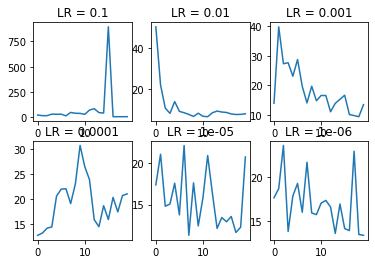

In [17]:

debug=False
tune_lr=True
loss_type='lifted'
model_type='shallow'
transfer_weights=False

lrs=[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
fig,ax=plt.subplots(2,3)
ax=ax.ravel()
for lr_index,lr in enumerate(lrs):
  print("lr ", lr)
  # model config
  
  model_helper = cifar10vgg(debug,tune_lr,loss_type,model_type,transfer_weights,pretrained_model_path)

  # train/evaluate
  trained_model, losses = model_helper.train(model_helper.model,lr)
  ax[lr_index].plot(np.arange(len(losses[0])),losses[0])
  ax[lr_index].set_title('LR = %s' %(str(lr)))

save_path=os.path.join(results_path,'%s_%s_%s_tune_lr.png'%(loss_type,model_type,transfer_weights))
plt.savefig(save_path)

In [44]:
# model config
debug=True
tune_lr=False
loss_type='lifted'
model_type='vgg'
transfer_weights=True
init_learning_rate=1e-2
model_helper = cifar10vgg(debug,tune_lr,loss_type,model_type,transfer_weights,pretrained_model_path)

# train/evaluate
trained_model, losses = model_helper.train(model_helper.model,init_learning_rate)

Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.19016, saving model to ./Colab Notebooks/cifar10/lifted_vgg_True_0.01_saved_models/cifar10_best_model.h5
1/1 [==============================] - 2s 2s/step - loss: 0.9252 - accuracy: 0.1000 - val_loss: 0.1902 - val_accuracy: 0.0000e+00
Epoch 2/2

Epoch 00002: val_loss did not improve from 0.19016
1/1 [==============================] - 0s 204ms/step - loss: 0.3425 - accuracy: 0.0000e+00 - val_loss: 0.1908 - val_accuracy: 0.0000e+00


In [0]:

# load trained model settings and evaluate
debug=False
tune_lr=False
loss_type='lifted'
model_type='vgg'
transfer_weights=True
init_learning_rate=1e-4
load_weights=True
model_time='final'

model_path=os.path.join('.','Colab Notebooks','cifar10','%s_%s_%s_%s_saved_models'%(loss_type,model_type,transfer_weights,str(init_learning_rate)))
model_file_path=os.path.join(model_path,'cifar10_vgg_%s_model.h5'%(model_time))
new_model_helper = cifar10vgg(debug,tune_lr,loss_type,model_type,transfer_weights,pretrained_model_path,load_weights,model_file_path)

# new_model_helper=cifar10vgg(debug,tune_lr,loss_type='entropy',model_type='vgg')
# new_model_helper.model.load_weights(pretrained_model_path)

# evaluate on the processed dataset
(X_train,y_train),(X_test,y_test)=cifar10.load_data()
mean = np.mean(X_train,axis=(0,1,2,3))
std = np.std(X_train, axis=(0, 1, 2, 3))
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)

if debug:
  X_test=X_test[0:10]
  y_test=y_test[0:10]


# relevant for classification models
# y_preds=new_model_helper.model.predict(X_test)
# y_preds_labels=np.argmax(y_preds,axis=1)
# np.sum(y_preds_labels==y_test[:,0])/len(y_test)

In [0]:
# performance measures

# evaluate performance of model using Recall@K

# retrieve k nearest neighbors based on embeddings


# pairwise distance matrix computation: 
# https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow


@tf.function
def forward(A):
  r = tf.reduce_sum(A*A, 1)
  r = tf.reshape(r, [-1, 1])
  D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
  return D
# A = tf.constant([[1, 1], [2, 2], [3, 3]])
# res=forward(A)
# print(res)


"""
D: 2d array num_samplesxnum_samples (num_samples >=2)
test_labels: 1d array num_samples
k: int # nearest neighbors >=1
"""
def compute_recall_at_k(Dist_matrix,test_labels,k):
  num_samples=Dist_matrix.shape[0]
  recall=0
  for sample_index in range(num_samples):
    ind_samples_sorted_by_distance=np.argsort(Dist_matrix[sample_index])
    # assert ind_samples_sorted_by_distance[0]==sample_index
    ind_samples_sorted_by_distance=ind_samples_sorted_by_distance[1:]# exclude the sample in question
    
    ind_nearest_k_neighbors=ind_samples_sorted_by_distance[:k]
    labels_nearest_k_neighbors=test_labels[ind_nearest_k_neighbors]
    true_label=test_labels[sample_index]

    if true_label in labels_nearest_k_neighbors:
      recall+=1

  recall*=(1.0/num_samples)

  return recall


# test compute_recall_at_k

# recall = 1, recall < 1
from sklearn.datasets import make_spd_matrix
np.random.seed(15)
num_samples=6
D=make_spd_matrix(num_samples)
D=np.abs(D)
for i in range(num_samples):
  D[i,i]=0

test_labels=np.random.randint(0,3,size=num_samples)
test_labels[-1]=1

recall_score=compute_recall_at_k(D,test_labels,k=num_samples)
assert np.allclose(recall_score,1.0)

recall_score=compute_recall_at_k(D,test_labels,k=1)
assert np.allclose(recall_score,1./6)

recall_score=compute_recall_at_k(D,test_labels,k=2)
assert np.allclose(recall_score,2./3)

recall_score=compute_recall_at_k(D,test_labels,k=3)
assert np.allclose(recall_score,2./3)

recall_score=compute_recall_at_k(D,test_labels,k=4)
assert np.allclose(recall_score,1.0)

recall_score=compute_recall_at_k(D,test_labels,k=5)
assert np.allclose(recall_score,1.0)






In [120]:
new_model_helper.model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_323 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_340 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_328 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_254 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_324 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_341 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_329 (Bat (None, 32, 32, 64)      

In [0]:
# evaluate model at other layers



# choose an embedding layer to evaluate

embed_layer_index=-5
embeddings_layer_model=tf.keras.models.Model(inputs=new_model_helper.model.input,outputs=new_model_helper.model.layers[embed_layer_index].output)


computing takes  0.19114651679992675
computing takes  0.19117084741592408
computing takes  0.19278321266174317
computing takes  0.19087959130605062


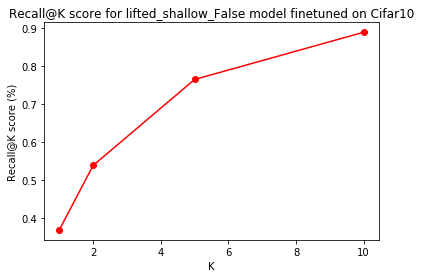

In [105]:

# evaluate performance

# smaller_test_dataset=test_dataset.take(num_batches_to_take)
smaller_test_dataset=X_test
test_labels=y_test

# embeddings_layer_model=models
predictions=embeddings_layer_model.predict(smaller_test_dataset)

# computes pairwise distance between the rows of predictions
D=forward(predictions)

import time
Ks=[1,2,5,10]
recall_by_k=[]
for k in Ks:
  t_start=time.time()
  recall_at_k=compute_recall_at_k(D,test_labels,k)
  t_end=time.time()
  print("computing takes ", (t_end-t_start)*1.0/60) 
  recall_by_k.append(recall_at_k)
recall_by_k=np.array(recall_by_k)


plt.figure()
plt.plot(Ks,recall_by_k,color='r',marker='o')
plt.ylabel('Recall@K score (%)')
plt.xlabel('K')
plt.title('Recall@K score for %s_%s_%s model finetuned on Cifar10' %(loss_type,model_type,transfer_weights))
plt.savefig(os.path.join(model_path,'recall_by_k_%s_model.png'%(model_time)))

np.save(os.path.join(model_path,'recall_by_k_%s_model.npy'%(model_time)),recall_by_k)

In [0]:
# evaluate sim judgments

data_source_dir=os.path.join('.','COS597D_proj/data/cifar10h')
model_source_path=os.path.join('.', 'Colab Notebooks')


# load human similarity data

test_data_soft_labels=np.load(os.path.join(data_source_dir,'cifar10h-probs.npy'))

# load ind - label name maps

label_name_map_file=os.path.join(data_source_dir,'cifar-10-batches-py','batches.meta')
with open(label_name_map_file, 'rb') as fo:
    label_name_map = pickle.load(fo, encoding='bytes')

label_ind_to_name=np.array(label_name_map[b'label_names'])
label_ind_to_name_list=list(label_ind_to_name)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

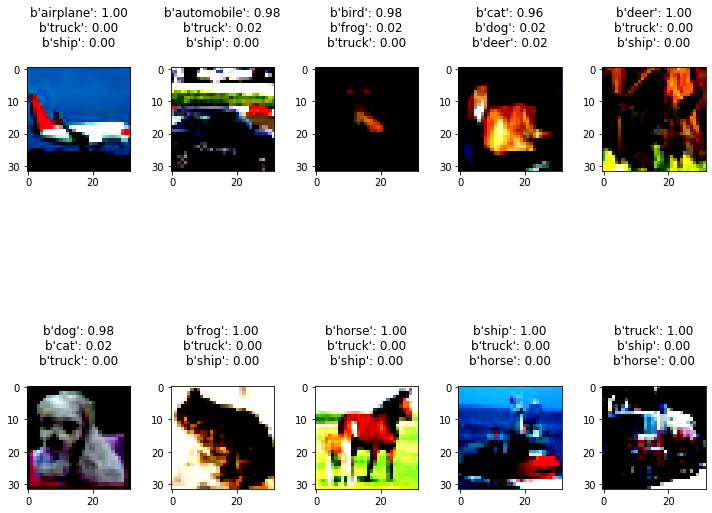

In [18]:
# quick visual sanity check


num_classes=10
sample_ind_by_class=[]
for class_index in range(num_classes):
  sample_index=np.random.choice(np.where(y_test==class_index)[0])
  sample_ind_by_class.append(sample_index)

sample_ind_by_class=np.array(sample_ind_by_class)
num_top_scores=3

fig,ax=plt.subplots(2,5,figsize=(10,10))
ax=ax.ravel()
for class_index in range(num_classes):
  ax[class_index].imshow(X_test[sample_ind_by_class[class_index]])
  ind_top_classes=np.argsort(test_data_soft_labels[sample_ind_by_class[class_index]])[::-1]
  ind_top_classes_scores=test_data_soft_labels[sample_ind_by_class[class_index]][ind_top_classes]
  labels_reformatted=''
  for i in range(num_top_scores):
    labels_reformatted+=(str(label_ind_to_name_list[ind_top_classes[i]]) + ": %.2f" %(ind_top_classes_scores[i]))
    labels_reformatted+='\n'
  # labels_reformatted = '\n'.join(map(str, list(label_ind_to_name[ind_top_classes[:4]])))
  ax[class_index].set_title(labels_reformatted)

plt.tight_layout()


In [0]:
# analyze the soft label and compute similarity 

from sklearn.metrics.pairwise import cosine_similarity
test_data_soft_labels_similarity=cosine_similarity(test_data_soft_labels,test_data_soft_labels)

# symmetric matrix so remove the upper through diagonal
num_pairs=X_test.shape[0]
test_data_soft_labels_similarity_tril=test_data_soft_labels_similarity[np.tril_indices(num_pairs,k=-1)]



In [0]:
# compute intra/inter class similarities

intra_class_sim_by_class=[]
inter_class_sim_by_class=[]
for class_index in range(num_classes):
  ind_target_class=np.where(y_test==class_index)[0]
  ind_non_target_class=np.setdiff1d(np.arange(num_classes),ind_target_class)
  intra_class_sim=cosine_similarity(test_data_soft_labels[ind_target_class],test_data_soft_labels[ind_target_class])
  inter_class_sim=cosine_similarity(test_data_soft_labels[ind_target_class],test_data_soft_labels[ind_non_target_class])

  intra_class_sim_by_class.append(np.mean(intra_class_sim))
  inter_class_sim_by_class.append(np.mean(inter_class_sim))
  # print(np.amin(intra_class_sim), np.mean(intra_class_sim), np.amax(intra_class_sim))
  # print(np.amin(inter_class_sim), np.mean(inter_class_sim), np.amax(inter_class_sim))

intra_class_sim_by_class=np.array(intra_class_sim_by_class)
inter_class_sim_by_class=np.array(inter_class_sim_by_class)

print(intra_class_sim_by_class)
print(inter_class_sim_by_class)
print(np.mean(intra_class_sim_by_class),np.std(intra_class_sim_by_class))
print(np.mean(inter_class_sim_by_class),np.std(inter_class_sim_by_class))

In [122]:

x_test_embeds=embeddings_layer_model.predict(X_test)

num_pairs=X_test.shape[0]
nn_sim=cosine_similarity(x_test_embeds,x_test_embeds)
nn_sim_tril=nn_sim[np.tril_indices(num_pairs,k=-1)]
np.corrcoef(nn_sim_tril,test_data_soft_labels_similarity_tril)**2

array([[1.        , 0.76921244],
       [0.76921244, 1.        ]])

In [0]:
# compare recall at k curves among the models
